In [1]:
%matplotlib inline
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu


In [2]:
new_model_ws = "smoother"

In [3]:
m = flopy.modflow.Modflow.load("box.nam",model_ws=os.path.join("..","model"))

In [4]:
m.lpf.hk[0] = 2.5
m.rch.rech = 0.000025
m.model_ws = "temp"
m.write_input()


changing model workspace...
   temp


In [5]:
grid_props = [["lpf.hk",0],["rch.rech",None]]
pp_props = None
const_props = [["rch.rech",0],["rch.rech",1]]
bc_props = [["drn.cond",[0,1]],["riv.cond",[0,1]]]
hds_kperk = [[0,0],[1,0]]
pst_helper = pyemu.helpers.PstFromFlopyModel(model='box.nam',org_model_ws="temp",new_model_ws=new_model_ws,
                                            pp_props=pp_props,remove_existing=True,
                                            const_props=const_props,bc_props=bc_props,
                                            hds_kperk=hds_kperk,pp_space=4,grid_props=grid_props)


2017-12-03 21:01:58.507393 starting: loading flopy model
2017-12-03 21:01:58.570323 finished: loading flopy model took: 0:00:00.062930
2017-12-03 21:01:58.570421 starting: updating model attributes
2017-12-03 21:01:58.570475 finished: updating model attributes took: 0:00:00.000054
2017-12-03 21:01:58.570519 WARNING: removing existing 'new_model_ws

creating model workspace...
   smoother

changing model workspace...
   smoother
2017-12-03 21:01:59.028214 starting: writing new modflow input files
Util2d:delr: resetting 'how' to external
Util2d:delc: resetting 'how' to external
Util2d:model_top: resetting 'how' to external
Util2d:botm_layer_0: resetting 'how' to external
Util2d:ibound_layer_0: resetting 'how' to external
Util2d:strt_layer_0: resetting 'how' to external
Util2d:hk: resetting 'how' to external
Util2d:vk: resetting 'how' to external
Util2d:ss: resetting 'how' to external
Util2d:rech_1: resetting 'how' to external
Util2d:rech_2: resetting 'how' to external
2017-12-03 21:01:59

/Users/jeremyw/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/jeremyw/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


2017-12-03 21:04:10.032715 finished: building prior covariance matrix took: 0:02:02.422232
2017-12-03 21:04:10.032889 starting: saving intermediate _setup_<> dfs into smoother
2017-12-03 21:04:10.092385 finished: saving intermediate _setup_<> dfs into smoother took: 0:00:00.059496
2017-12-03 21:04:10.092561 all done


In [6]:
pst = pst_helper.pst

df = pd.read_csv(os.path.join("..","model","_setup_box.hds.csv"))
df.index = df.obsnme
obs = pst.observation_data
obs.loc[:,"weight"] = 0.0
obs.loc[df.obsnme,"weight"] = df.weight
obs.loc[df.obsnme,"obsval"] = df.obsval

df = pd.read_csv(os.path.join("..","model","_setup_box.list.csv"))
obs.loc[obs.obgnme=="flx_river_l","obsval"] = df.loc[:,"river_leakage"].values
obs.loc[obs.obgnme=="flx_drains","obsval"] = df.loc[:,"drains"].values

pst.nnz_obs
forecasts = []
forecasts.append(obs.loc[obs.obgnme=="flx_river_l","obsnme"][-1])
forecasts.append(obs.loc[obs.obgnme=="flx_drains","obsnme"][-1])
forecasts.append("hds_00_080_060_001")
forecasts.append("hds_00_050_050_001")

pst.pestpp_options["forecasts"] = ','.join(forecasts)
pst.control_data.noptmax = 0
pst.write(os.path.join(new_model_ws,"box.pst"))
pyemu.helpers.run("pestpp box.pst",cwd=new_model_ws)

run():pestpp box.pst


In [7]:
pst = pyemu.Pst(os.path.join(new_model_ws,"box.pst"))

In [8]:
pst.res.loc[pst.nnz_obs_names,:]

name   group  measured  modelled  residual  \
name                                                                           
hds_00_020_030_000  hds_00_020_030_000  obgnme -0.018876 -4.520337  4.501461   
hds_00_020_060_000  hds_00_020_060_000  obgnme  0.223111 -4.357847  4.580958   
hds_00_040_030_000  hds_00_040_030_000  obgnme -1.118615 -5.184079  4.065464   
hds_00_040_060_000  hds_00_040_060_000  obgnme -0.422204 -4.844365  4.422161   
hds_00_060_030_000  hds_00_060_030_000  obgnme -2.323823 -6.266079  3.942256   
hds_00_060_060_000  hds_00_060_060_000  obgnme -1.637360 -5.558151  3.920791   
hds_00_080_030_000  hds_00_080_030_000  obgnme -4.534806 -7.168790  2.633984   
hds_00_080_060_000  hds_00_080_060_000  obgnme -3.497677 -6.391021  2.893344   

                    weight  
name                        
hds_00_020_030_000     2.0  
hds_00_020_060_000     2.0  
hds_00_040_030_000     2.0  
hds_00_040_060_000     2.0  
hds_00_060_030_000     2.0  
hds_00_060_060_000     2.0  
hds_00_080_030_000     2.0  
hds_00_080_060_000     2.0

In [9]:
bdir = os.getcwd()

shutil.copytree(new_model_ws,os.path.join(new_model_ws,"template"))
covs = [f for f in os.listdir(os.path.join(new_model_ws,"template")) if ".cov" in f]
for cov in covs:
    os.remove(os.path.join(new_model_ws,"template",cov))
os.chdir(new_model_ws)

In [10]:
# mc = pyemu.MonteCarlo(pst=pst)
# cov = pyemu.Cov.from_ascii("box_pest.pst.prior.cov")
# pe = pyemu.ParameterEnsemble.from_gaussian_draw(mc.parensemble,cov,num_reals=100)
# oe = pyemu.ObservationEnsemble.from_id_gaussian_draw(mc.obsensemble,num_reals=100)


In [11]:
#cov = pyemu.Cov.from_ascii("box_pest.pst.prior.cov")
ies = pyemu.EnsembleSmoother(pst="box.pst",parcov=pst_helper.parcov,verbose=True,num_slaves=10,drop_bad_reals=1200)

In [12]:
ies.initialize(num_reals=200,init_lambda=10.0)

2017-12-03 21:04:21.003707 starting: initializing smoother with 200 realizations
2017-12-03 21:04:21.004010 starting: initializing parensemble
making full cov draws
back transforming
handling fixed pars
2017-12-03 21:15:23.604609 finished: initializing parensemble took: 0:11:02.600599
2017-12-03 21:15:28.108821 starting: initializing parensemble
2017-12-03 21:15:28.108997 starting: initializing obsensemble
2017-12-03 21:15:57.869782 finished: initializing obsensemble took: 0:00:29.760785
2017-12-03 21:15:57.869897 finished: initializing smoother with 200 realizations took: 0:11:36.866190
2017-12-03 21:15:57.910555 starting: evaluating initial ensembles
2017-12-03 21:15:57.910683 starting: removing existing sweep in/out files
2017-12-03 21:15:57.910768 WARNING: error removing existing sweep in file:[Errno 2] No such file or directory: 'sweep_in.csv'
2017-12-03 21:15:57.910812 WARNING: error removing existing sweep out file:[Errno 2] No such file or directory: 'sweep_out.csv'
2017-12-03 

In [13]:
for _ in range(10):
    ies.update(lambda_mults=[0.01,1.0,100.0],run_subset=30)


2017-12-03 21:18:18.706178 starting: iteration 1
2017-12-03 21:18:18.706472 195 active realizations
2017-12-03 21:18:18.706569 starting: calculate scaled delta obs
2017-12-03 21:18:18.814681 finished: calculate scaled delta obs took: 0:00:00.108112
2017-12-03 21:18:18.814806 starting: calculate scaled delta par
2017-12-03 21:18:19.010924 finished: calculate scaled delta par took: 0:00:00.196118
2017-12-03 21:18:19.011056 starting: calculate pseudo inv comps
2017-12-03 21:18:19.012345 finished: calculate pseudo inv comps took: 0:00:00.001289
2017-12-03 21:18:19.012513 starting: calculate obs diff matrix
2017-12-03 21:18:19.057226 finished: calculate obs diff matrix took: 0:00:00.044713
2017-12-03 21:18:19.114262 starting: calcs for  lambda 0.01
2017-12-03 21:18:19.114807 starting: building upgrade_1 matrix
2017-12-03 21:18:19.167859 finished: building upgrade_1 matrix took: 0:00:00.053052
2017-12-03 21:18:19.167957 starting: applying residuals
2017-12-03 21:18:19.179026 finished: applyi

2017-12-03 21:26:59.480254 finished: processing upgrade_1 took: 0:00:03.342676
2017-12-03 21:27:57.092601 finished: calcs for  lambda 100.0 took: 0:01:01.015249
2017-12-03 21:27:57.092925 subset idxs: 0,2,4,5,6,7,9,10,11,14,15,17,19,21,22,23,28,29,30,32,35,36,39,42,45,49,50,51,52,53
2017-12-03 21:27:57.109258 starting: evaluating ensembles for lambdas : 7.500E-04,7.500E-02,7.500E+00
2017-12-03 21:27:57.109373 starting: removing existing sweep in/out files
2017-12-03 21:27:57.117240 finished: removing existing sweep in/out files took: 0:00:00.007867
2017-12-03 21:27:57.119027 starting: evaluating ensemble of size 90 locally with sweep
run():sweep box.pst /h :4004 1>_master_stdout.dat 2>_master_stderr.dat
slave:sweep box.pst /h localhost:4004 in ../slave_0
slave:sweep box.pst /h localhost:4004 in ../slave_1
slave:sweep box.pst /h localhost:4004 in ../slave_2
slave:sweep box.pst /h localhost:4004 in ../slave_3
slave:sweep box.pst /h localhost:4004 in ../slave_4
slave:sweep box.pst /h loca

2017-12-03 21:34:52.310393 finished: removing existing sweep in/out files took: 0:00:00.004407
2017-12-03 21:34:52.312132 starting: evaluating ensemble of size 130 locally with sweep
run():sweep box.pst /h :4004 1>_master_stdout.dat 2>_master_stderr.dat
slave:sweep box.pst /h localhost:4004 in ../slave_0
slave:sweep box.pst /h localhost:4004 in ../slave_1
slave:sweep box.pst /h localhost:4004 in ../slave_2
slave:sweep box.pst /h localhost:4004 in ../slave_3
slave:sweep box.pst /h localhost:4004 in ../slave_4
slave:sweep box.pst /h localhost:4004 in ../slave_5
slave:sweep box.pst /h localhost:4004 in ../slave_6
slave:sweep box.pst /h localhost:4004 in ../slave_7
slave:sweep box.pst /h localhost:4004 in ../slave_8
slave:sweep box.pst /h localhost:4004 in ../slave_9
2017-12-03 21:36:18.257206 finished: evaluating ensemble of size 130 locally with sweep took: 0:01:25.945074
2017-12-03 21:36:18.257437 starting: reading sweep out csv sweep_out.csv
2017-12-03 21:36:19.505137 finished: reading

2017-12-03 21:42:24.860136 finished: processing upgrade_1 took: 0:00:03.718479
2017-12-03 21:43:23.377704 finished: calcs for  lambda 0.01 took: 0:01:02.290024
2017-12-03 21:43:23.428180 starting: calcs for  lambda 1.0
2017-12-03 21:43:23.428570 starting: building upgrade_1 matrix
2017-12-03 21:43:23.478242 finished: building upgrade_1 matrix took: 0:00:00.049672
2017-12-03 21:43:23.478350 starting: applying residuals
2017-12-03 21:43:23.486992 finished: applying residuals took: 0:00:00.008642
2017-12-03 21:43:23.487073 starting: processing upgrade_1
2017-12-03 21:43:27.164962 finished: processing upgrade_1 took: 0:00:03.677889
2017-12-03 21:44:27.355002 finished: calcs for  lambda 1.0 took: 0:01:03.926822
2017-12-03 21:44:27.404710 starting: calcs for  lambda 100.0
2017-12-03 21:44:27.405086 starting: building upgrade_1 matrix
2017-12-03 21:44:27.456033 finished: building upgrade_1 matrix took: 0:00:00.050947
2017-12-03 21:44:27.456138 starting: applying residuals
2017-12-03 21:44:27.

2017-12-03 21:52:20.520681 finished: evaluating ensemble of size 90 locally with sweep took: 0:01:02.226298
2017-12-03 21:52:20.520963 starting: reading sweep out csv sweep_out.csv
2017-12-03 21:52:21.446681 finished: reading sweep out csv sweep_out.csv took: 0:00:00.925718
2017-12-03 21:52:21.446817 total runs:1455
2017-12-03 21:52:21.446867 finished: evaluating ensembles for lambdas : 2.373E-02,2.373E+00,2.373E+02 took: 0:01:03.159741
2017-12-03 21:52:21.481575 
**************************
2017-12-03 21:52:21.481683 2017-12-03 21:52:21.481677
2017-12-03 21:52:21.481712 total runs:1455
2017-12-03 21:52:21.481740 iteration: 6
2017-12-03 21:52:21.481772 current lambda:        2.37305, mean:        6.34366, std:        9.43193
2017-12-03 21:52:21.614722  tested lambda:      0.0237305, mean:        2.99005, std:        2.08725
2017-12-03 21:52:21.614824  tested lambda:        2.37305, mean:         3.4805, std:        2.12996
2017-12-03 21:52:21.614853  tested lambda:        237.305, mean:

2017-12-03 21:59:47.979751 finished: iteration 7 took: 0:05:46.703438
2017-12-03 21:59:47.984325 starting: iteration 8
2017-12-03 21:59:47.984431 130 active realizations
2017-12-03 21:59:47.984459 starting: calculate scaled delta obs
2017-12-03 21:59:48.099815 finished: calculate scaled delta obs took: 0:00:00.115356
2017-12-03 21:59:48.099938 starting: calculate scaled delta par
2017-12-03 21:59:48.279645 finished: calculate scaled delta par took: 0:00:00.179707
2017-12-03 21:59:48.279780 starting: calculate pseudo inv comps
2017-12-03 21:59:48.280916 finished: calculate pseudo inv comps took: 0:00:00.001136
2017-12-03 21:59:48.281140 starting: calculate obs diff matrix
2017-12-03 21:59:48.331308 finished: calculate obs diff matrix took: 0:00:00.050168
2017-12-03 21:59:48.377708 starting: calcs for  lambda 0.01
2017-12-03 21:59:48.378238 starting: building upgrade_1 matrix
2017-12-03 21:59:48.426145 finished: building upgrade_1 matrix took: 0:00:00.047907
2017-12-03 21:59:48.426248 st

2017-12-03 22:07:51.294961 finished: processing upgrade_1 took: 0:00:03.525187
2017-12-03 22:08:50.772563 finished: calcs for  lambda 100.0 took: 0:01:03.061097
2017-12-03 22:08:50.773026 subset idxs: 0,2,4,5,6,7,9,10,11,14,15,17,19,21,22,23,28,29,30,32,35,36,39,42,45,49,50,51,52,53
2017-12-03 22:08:50.792062 starting: evaluating ensembles for lambdas : 1.001E-02,1.001E+00,1.001E+02
2017-12-03 22:08:50.792219 starting: removing existing sweep in/out files
2017-12-03 22:08:50.799315 finished: removing existing sweep in/out files took: 0:00:00.007096
2017-12-03 22:08:50.801487 starting: evaluating ensemble of size 90 locally with sweep
run():sweep box.pst /h :4004 1>_master_stdout.dat 2>_master_stderr.dat
slave:sweep box.pst /h localhost:4004 in ../slave_0
slave:sweep box.pst /h localhost:4004 in ../slave_1
slave:sweep box.pst /h localhost:4004 in ../slave_2
slave:sweep box.pst /h localhost:4004 in ../slave_3
slave:sweep box.pst /h localhost:4004 in ../slave_4
slave:sweep box.pst /h loca

KeyboardInterrupt: 

In [14]:
df = pd.read_csv("box.pst.iobj.csv")

In [15]:
df

iter_num  total_runs    lambda        min          max        mean  \
0         0         200  0.000000  10.022701  1190.987605  503.251911   
1         1         485  0.100000   6.782359  1097.491304  284.580154   
2         2         705  7.500000   3.135704   450.384345   75.183217   
3         3         925  5.625000   1.851565   289.642268   28.632747   
4         4        1145  0.042188   0.975855   190.712705   16.007509   
5         5        1365  3.164062   0.854854    98.280068    6.343657   
6         6        1585  0.023730   0.070806    46.867280    4.466741   
7         7        1805  1.779785   0.026943    47.768153    3.118946   
8         8        2025  1.334839   0.016205    20.415258    2.695741   
9         9        2245  0.010011   0.013155    35.064227    2.724472   

                                   median         std  0000000001  0000000002  \
0  494.13672609302773           238.77304  345.131460  174.791830  965.007620   
1  146.68659947254034           383.48938  355.820000   29.970331  189.427840   
2   49.61524237824548           24.125575   84.790439   15.969016   60.925911   
3  14.803012619609486           16.721782   32.199482   12.446202   23.981065   
4   7.294644451263208           7.0493708    6.818978    5.463937   10.006315   
5   4.026896607222287           5.6543722    8.754614    5.209818    7.798173   
6  3.2664362522419665           3.7964845    2.778579    4.716379    1.830101   
7  2.4198991295205783           3.3308514    1.065875    4.018087    1.336557   
8    2.20867642493365           2.8526866    0.858191    3.880190    0.972668   
9  1.7616960356800577           2.3319875    0.446721    3.523467    0.625527   

      ...      0000000191  0000000192  0000000193  0000000194  0000000195  \
0     ...       109.45671   859.95906    407.0467         NaN         NaN   
1     ...             NaN         NaN         NaN         NaN         NaN   
2     ...             NaN         NaN         NaN         NaN         NaN   
3     ...             NaN         NaN         NaN         NaN         NaN   
4     ...             NaN         NaN         NaN         NaN         NaN   
5     ...             NaN         NaN         NaN         NaN         NaN   
6     ...             NaN         NaN         NaN         NaN         NaN   
7     ...             NaN         NaN         NaN         NaN         NaN   
8     ...             NaN         NaN         NaN         NaN         NaN   
9     ...             NaN         NaN         NaN         NaN         NaN   

   0000000196  0000000197  0000000198  0000000199  0000000200  
0         NaN         NaN         NaN         NaN         NaN  
1         NaN         NaN         NaN         NaN         NaN  
2         NaN         NaN         NaN         NaN         NaN  
3         NaN         NaN         NaN         NaN         NaN  
4         NaN         NaN         NaN         NaN         NaN  
5         NaN         NaN         NaN         NaN         NaN  
6         NaN         NaN         NaN         NaN         NaN  
7         NaN         NaN         NaN         NaN         NaN  
8         NaN         NaN         NaN         NaN         NaN  
9         NaN         NaN         NaN         NaN         NaN  

[10 rows x 208 columns]

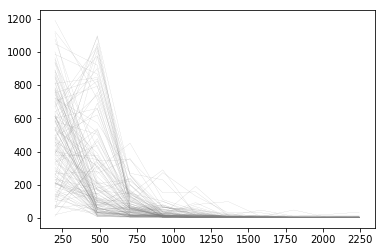

In [16]:
ax = plt.subplot(111)
for col in df.columns[8:]:
    ax.plot(df.total_runs,df.loc[:,col],"0.5",lw=0.1)
plt.show()

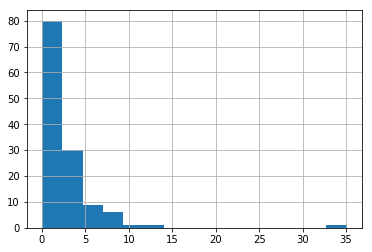

In [17]:
df.iloc[-1,8:].hist(bins=15)

In [18]:
obs_csvs = [f for f in os.listdir('.') if "obsensemble" in f and f.endswith(".csv")]

In [19]:
inum = [int(f.split('.')[3]) for f in obs_csvs]

In [20]:
oe_init = pd.read_csv(obs_csvs[inum.index(0)])
oe_final = pd.read_csv(obs_csvs[inum.index(max(inum))])

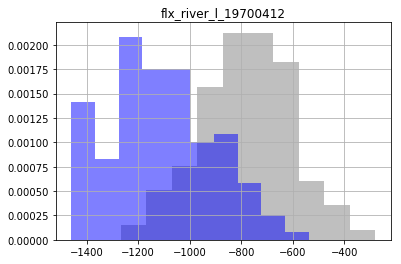

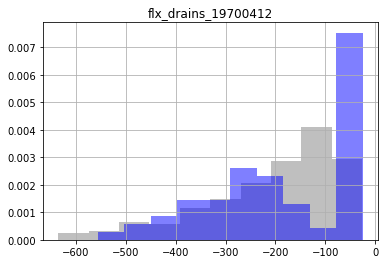

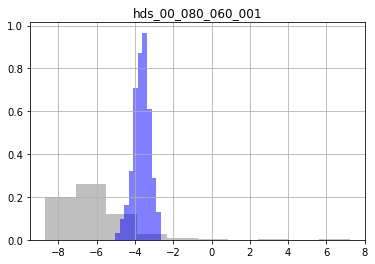

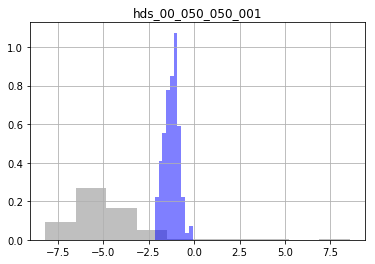

In [21]:
for forecast in pst.forecast_names:
    ax = oe_init.loc[:,forecast].hist(bins=10,facecolor="0.5",alpha=0.5,normed=True)
    oe_final.loc[:,forecast].hist(bins=10,facecolor="b",alpha=0.5,ax=ax,normed=True)
    #ax.set_xlim(oe_final.loc[:,forecast].min(),oe_final.loc[:,forecast].max())
    ax.set_title(forecast)
    plt.show()